# Heart Disease Classifier – Final Project

In [263]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

## 1. Data Loading & Cleaning

Our dataset (https://archive.ics.uci.edu/dataset/45/heart+disease) have 14 features, two of which (ca and thal) have missing values. We checked the dataset and found that 6 rows contain missing values. From here we have two main options to make the dataset usable.

1. **Exclude the 6 incomplete rows:** This is simple and safe. The dataset contains 303 rows, so removing 6 will reduce the size to roughly 98% which most likely wont affect the performance a lot. However, this solution assumes that the missing data have no correlation to the other values.
2. **Fill the missing data using the mean or mode:** For numerical features (like ca), the mean can be used. And for categorical features (like thal), the mode can be used
3. **Predict the missing values:** We could also try to predict the values using regression or KNN

**Our choice:** We choose the first option since it keeps the cleaning process simple and avoids inacurrate assumptions that could affect our results.P

In [264]:
# Load the data
df = pd.read_csv("./heart+disease/processed.cleveland.data", header=None, na_values="?")

# Add column names (from the 14 features)
df.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
]

# Check for missing values
print(df.isna().sum())

# Drop all the rows that are incomplete
df_clean = df.dropna()

print(f"Original size: {len(df)} rows")
print(f"After dropping missing: {len(df_clean)} rows")
# 6 rows dropped. Seems to check out!

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64
Original size: 303 rows
After dropping missing: 297 rows


## 2. Exploratory Data Analysis (EDA)

First, we'll take a look at all the features to see what are numerical and what are categorical. The infromation for the data set says that all of the values are transfered to numerical which is good! But for the PCA and GMM in 3.

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  num  
0    3.0  0.0   6.0    0  
1    2.0  3.0   3.0    2  
2    2.0  2.0   7.0    1  
3    3.0  0.0   3.0    0  
4    1.0  0.0   3.0    0  
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
dtype: object


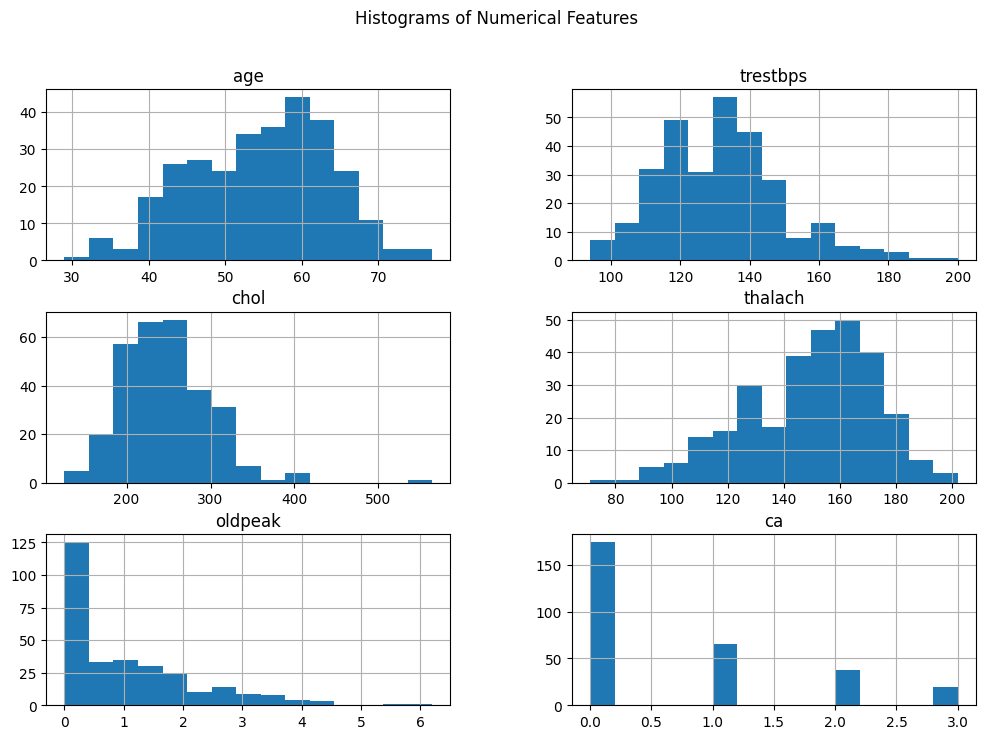

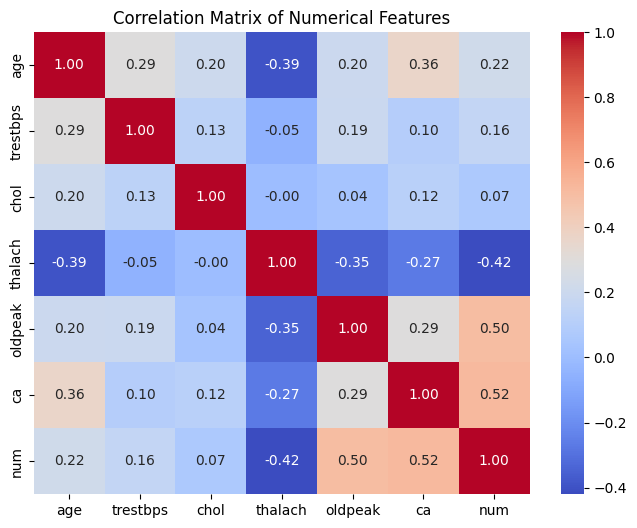

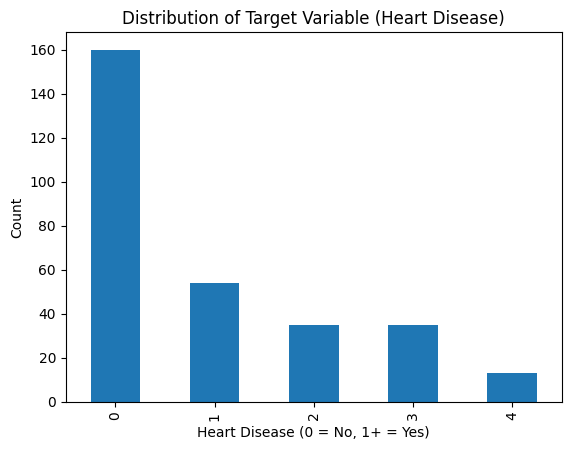

In [265]:
# Preview the first few rows
print(df_clean.head())

# Check data types
print(df_clean.dtypes)

# All the numerical features
numerical_features = [ "age", "trestbps", "chol", "thalach", "oldpeak", "ca", "num" ]
X_numerical = df_clean[numerical_features]
X_unsupervised = X_numerical.drop(columns="num")

# We dont want the labeldata for the unsupervised learning.
X_unsupervised.hist(bins=15, figsize=(12, 8))
plt.suptitle("Histograms of Numerical Features")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(X_numerical.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

df_clean["num"].value_counts().plot(kind="bar")
plt.title("Distribution of Target Variable (Heart Disease)")
plt.xlabel("Heart Disease (0 = No, 1+ = Yes)")
plt.ylabel("Count")
plt.show()

## 3. Unsupervised Learning: PCA + GMM

In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

def get_outliers(X_unsupervised_input, k, percentile_threshold):
    X_unsupervised_processed = X_unsupervised_input.copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_unsupervised_processed)

    pca = PCA(n_components=k, random_state=42) # Added random_state for PCA for reproducibility
    X_pca = pca.fit_transform(X_scaled)

    # Increased max_iter to give GMM more chances to converge
    gmm = GaussianMixture(n_components=2, random_state=42, max_iter=300)
    gmm.fit(X_pca)

    log_probs = gmm.score_samples(X_pca)
    
    threshold = np.quantile(log_probs, percentile_threshold)
    outliers = log_probs < threshold

    outlier_feature = pd.Series(outliers, index=X_unsupervised_processed.index, name='is_outlier')

    return outlier_feature.astype(int)

## 4. Supervised Learning: SVM, Random Forest, KNN, Linear Regression

In [267]:
"""function taken from lab 3"""
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    """taken from https://gist.github.com/zachguo/10296432"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth

    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t\p" + (columnwidth-3)//2 * " "

    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES

    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")

    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [268]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import ClassifierMixin

supervised_models = {}
supervised_model_data = {}

def _evaluate_model(model: ClassifierMixin, model_name: str, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series) -> dict:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    current_accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Generate classification report as a dictionary for structured metric extraction
    cls_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # Assuming '1' is the positive class, based on (df_final["num"] > 0).astype(int)
    positive_class_label = '1'
    
    # Safely extract metrics for the positive class
    precision_positive = cls_report[positive_class_label].get('precision', 0.0)
    recall_positive = cls_report[positive_class_label].get('recall', 0.0)
    f1_positive = cls_report[positive_class_label].get('f1-score', 0.0)

    return {
        'model_object': model, # Store the trained model object for later use/inspection
        'accuracy': current_accuracy,
        'confusion_matrix': cm.tolist(), # Convert NumPy array to list for easier storage/serialization (e.g., JSON)
        'precision_positive': precision_positive,
        'recall_positive': recall_positive,
        'f1_positive': f1_positive,
    }

# --- Helper for KNN Cross-Validation ---
def knn_get_best_k(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    param_grid = {'n_neighbors': range(1, 21)} # Common range for K
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    return grid_search.best_estimator_, grid_search.best_score_

# --- Helper for SVM Cross-Validation ---
def svm_get_best_params(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 1],
        'kernel': ['rbf', 'linear']
    }
    grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    return grid_search.best_estimator_, grid_search.best_score_

# --- Helper for Random Forest Cross-Validation ---
def rf_get_best_n(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200], # Number of trees
        'max_depth': [None, 5, 10] # Max depth of trees
    }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train) # RF typically does not need scaled data
    
    return grid_search.best_estimator_, grid_search.best_score_

# --- Helper for Logistic Regression Cross-Validation ---
def lr_get_best_params(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'] # 'liblinear' good for small datasets, 'lbfgs' for larger
    }
    grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    return grid_search.best_estimator_, grid_search.best_score_

def supervised_learning(X_train, X_test, y_train, y_test):
    all_detailed_metrics = {}
    trained_models = {}

    # Scaling for models sensitive to scale (KNN, SVM, Logistic Regression)
    # RF doesn't need scaling, so we pass original X_train/X_test for it.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- KNN Model (CV-optimized) ---
    best_knn_model_cv, best_cv_score_knn = knn_get_best_k(X_train, y_train) # Pass unscaled to helper, scaling is inside
    
    knn_metrics = _evaluate_model(best_knn_model_cv, "KNN (CV)", X_train_scaled, X_test_scaled, y_train, y_test)
    trained_models["KNN (CV)"] = knn_metrics['model_object']
    all_detailed_metrics["KNN (CV)"] = {**knn_metrics, 'cv_score': best_cv_score_knn}

    # --- SVM Model (CV-optimized) ---
    best_svm_model_cv, best_cv_score_svm = svm_get_best_params(X_train, y_train) # Pass unscaled to helper, scaling is inside
    
    svm_metrics = _evaluate_model(best_svm_model_cv, "SVM (CV)", X_train_scaled, X_test_scaled, y_train, y_test)
    trained_models["SVM (CV)"] = svm_metrics['model_object']
    all_detailed_metrics["SVM (CV)"] = {**svm_metrics, 'cv_score': best_cv_score_svm}

    # --- Random Forest Model (CV-optimized) ---
    best_rf_model_cv, best_cv_score_rf = rf_get_best_n(X_train, y_train) # RF doesn't need scaling
    
    rf_metrics = _evaluate_model(best_rf_model_cv, "Random Forest (CV)", X_train, X_test, y_train, y_test)
    trained_models["Random Forest (CV)"] = rf_metrics['model_object']
    all_detailed_metrics["Random Forest (CV)"] = {**rf_metrics, 'cv_score': best_cv_score_rf}

    # --- Logistic Regression Model (CV-optimized) ---
    best_lr_model_cv, best_cv_score_lr = lr_get_best_params(X_train, y_train) # Pass unscaled to helper, scaling is inside
    
    lr_metrics = _evaluate_model(best_lr_model_cv, "Logistic Regression (CV)", X_train_scaled, X_test_scaled, y_train, y_test)
    trained_models["Logistic Regression (CV)"] = lr_metrics['model_object']
    all_detailed_metrics["Logistic Regression (CV)"] = {**lr_metrics, 'cv_score': best_cv_score_lr}

    # --- Final Summary Prints (Minimal) ---
    print("\nSummary of Accuracies:")
    for name, metrics in all_detailed_metrics.items():
        print(f"- {name}: Acc={metrics.get('accuracy', np.nan):.4f}, CV_Score={metrics.get('cv_score', np.nan):.4f}")

    return all_detailed_metrics, trained_models


In [269]:
def define_input(split, df_clean_original):
    all_experiment_metrics = {}
    all_experiment_models = {}

    percentiles = np.arange(0.05, 0.55, 0.05) # This range correctly includes 0.05 up to 0.50

    # --- 1. Run for "No Outliers" ---
    # This will be treated as k=0 for a special column on your heatmap
    # And there's no percentile threshold as no outliers are removed.
    print("\n--- Running experiment for No Outliers (Baseline) ---")
    df_clean_local_no_outliers = df_clean_original.copy()
    
    # In this case, we do NOT add an 'is_outlier' column derived from GMM/PCA.
    # The dataframe goes directly to dummy encoding and splitting.
    
    categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
    df_final_no_outliers = pd.get_dummies(df_clean_local_no_outliers, columns=categorical_cols, drop_first=True)
    
    X_no_outliers = df_final_no_outliers.drop(columns=["num"])
    y_no_outliers = (df_final_no_outliers["num"] > 0).astype(int) 
    
    X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
        X_no_outliers, 
        y_no_outliers,
        test_size=split,
        random_state=42, 
        stratify=y_no_outliers
    )
    
    print(f"Features (X) shape for No Outliers: {X_no_outliers.shape}")
    print(f"Train/Test Split for No Outliers: X_train {X_train_no_outliers.shape}, X_test {X_test_no_outliers.shape}")

    current_detailed_metrics_no_outliers, current_trained_models_no_outliers = \
        supervised_learning(X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)
    
    # Use a specific key for the "No Outliers" case, e.g., (0, 0.0) or ('No Outliers', 'N/A')
    # Using (0, 0.0) allows it to fit numerically in a heatmap column if you desire.
    all_experiment_metrics[(0, 0.0)] = current_detailed_metrics_no_outliers
    all_experiment_models[(0, 0.0)] = current_trained_models_no_outliers

    # --- 2. Run for Outlier Scenarios (k=1 to 7) ---
    for k in range(1, 8):  # k: PCA components (1 to 7)
        for bottom_percentile in percentiles: # bottom_percentile: 0.05, 0.10, ..., 0.50
            print(f"\n--- Running experiment for PCA components: {k}, Outlier Threshold: {bottom_percentile:.2f} ---")
            
            df_clean_local = df_clean_original.copy() 
            
            # Pass ONLY the numerical features (excluding the target 'num') to get_outliers
            X_unsupervised_features = df_clean_original.select_dtypes(include=np.number).drop(columns=['num'], errors='ignore')
            is_outlier_series = get_outliers(X_unsupervised_features, k, bottom_percentile)
            df_clean_local['is_outlier'] = is_outlier_series # Add the new 'is_outlier' feature
            
            categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
            df_final = pd.get_dummies(df_clean_local, columns=categorical_cols, drop_first=True)
            
            X = df_final.drop(columns=["num"]) 
            y = (df_final["num"] > 0).astype(int) 
            
            X_train, X_test, y_train, y_test = train_test_split(
                X, 
                y,
                test_size=split,
                random_state=42, # Crucial for reproducibility
                stratify=y
            )
            
            print(f"Features (X) shape for this run: {X.shape}")
            print(f"Train/Test Split: X_train {X_train.shape}, X_test {X_test.shape}")

            current_detailed_metrics, current_trained_models = supervised_learning(X_train, X_test, y_train, y_test)
            
            key = (k, round(bottom_percentile, 2)) 
            all_experiment_metrics[key] = current_detailed_metrics
            all_experiment_models[key] = current_trained_models
            
    return all_experiment_metrics, all_experiment_models

In [ ]:
#all_metrics_for_heatmap, all_models_trained = define_input(0.2, df_clean)
#all_metrics_for_heatmap, all_models_trained = define_input(0.3, df_clean)
all_metrics_for_heatmap, all_models_trained = define_input(0.4, df_clean)
print("All experiments completed!")


--- Running experiment for No Outliers (Baseline) ---
Features (X) shape for No Outliers: (297, 18)
Train/Test Split for No Outliers: X_train (237, 18), X_test (60, 18)

Summary of Accuracies:
- KNN (CV): Acc=0.8333, CV_Score=0.8306
- SVM (CV): Acc=0.8667, CV_Score=0.8304
- Random Forest (CV): Acc=0.8167, CV_Score=0.8349
- Logistic Regression (CV): Acc=0.8333, CV_Score=0.8305

--- Running experiment for PCA components: 1, Outlier Threshold: 0.05 ---
Features (X) shape for this run: (297, 19)
Train/Test Split: X_train (237, 19), X_test (60, 19)

Summary of Accuracies:
- KNN (CV): Acc=0.8167, CV_Score=0.8306
- SVM (CV): Acc=0.8667, CV_Score=0.8304
- Random Forest (CV): Acc=0.8500, CV_Score=0.8307
- Logistic Regression (CV): Acc=0.8333, CV_Score=0.8348

--- Running experiment for PCA components: 1, Outlier Threshold: 0.10 ---
Features (X) shape for this run: (297, 19)
Train/Test Split: X_train (237, 19), X_test (60, 19)

Summary of Accuracies:
- KNN (CV): Acc=0.8167, CV_Score=0.8265
- SV

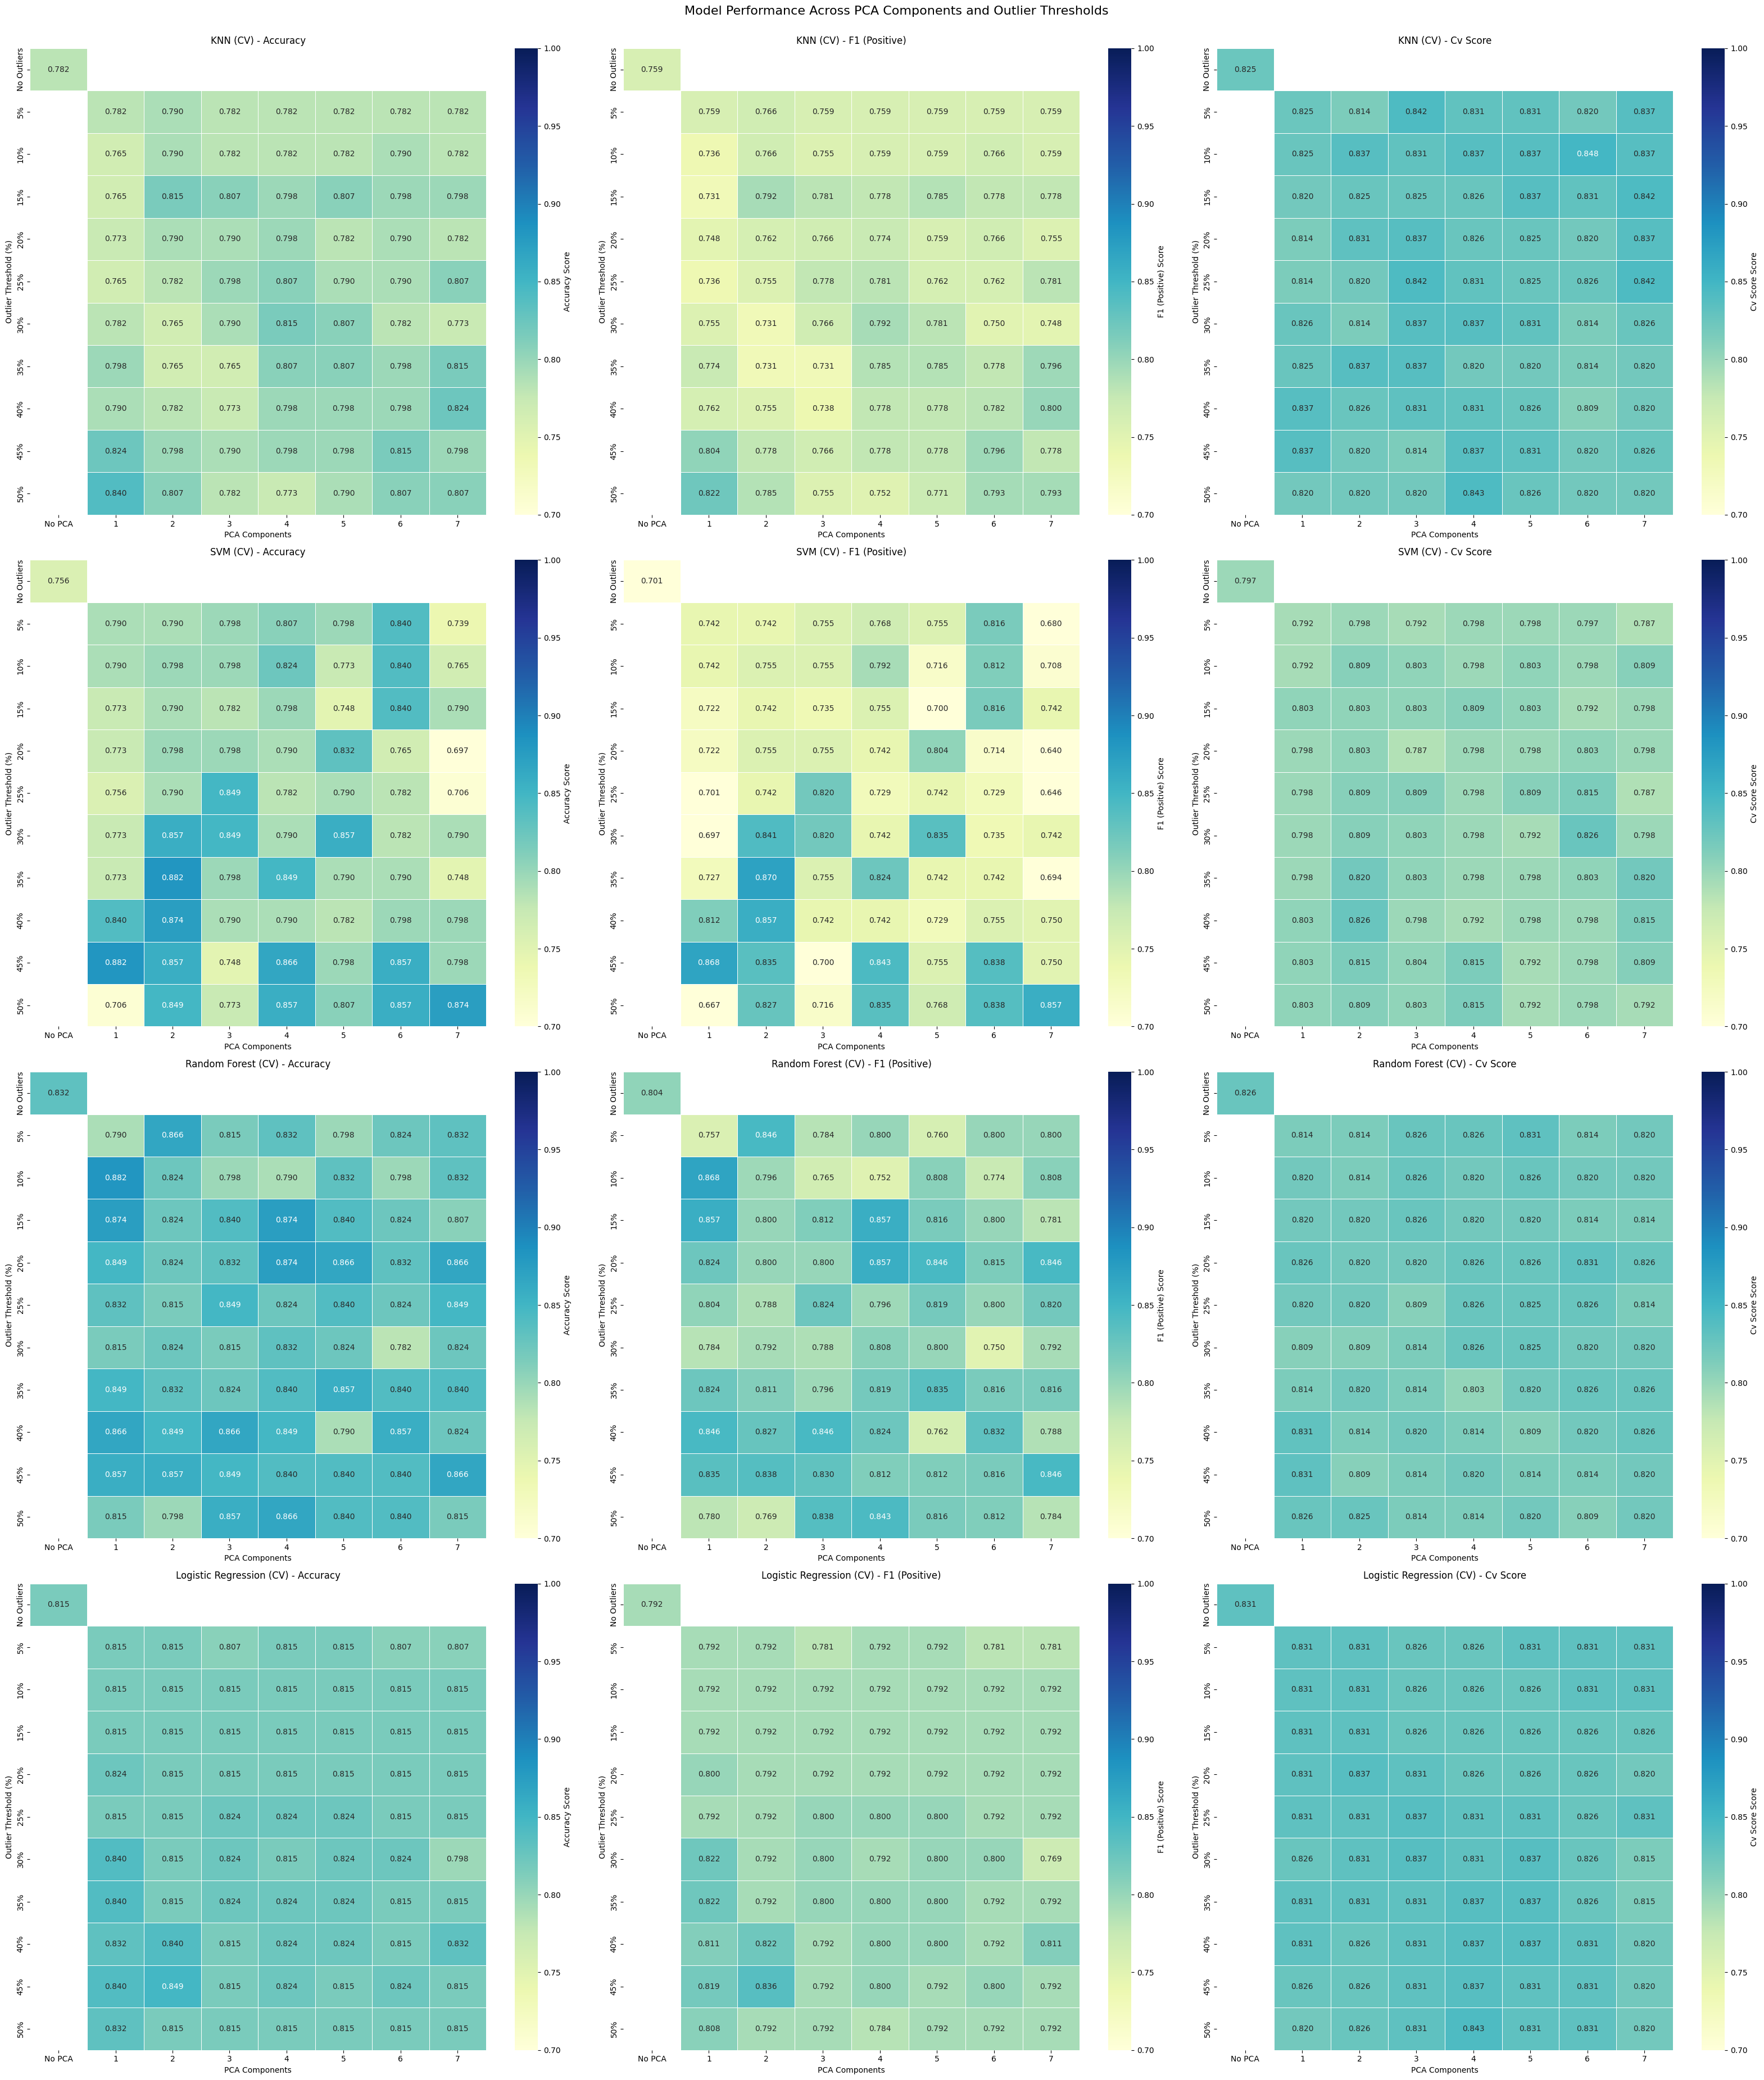


Heatmaps generated successfully!


In [275]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Ensure all_metrics_for_heatmap is available ---
# IMPORTANT: This variable should be populated by your define_input call.
# If you're testing this heatmap code *without* running define_input first,
# you can use the DUMMY DATA below for demonstration.
# Otherwise, make sure your actual define_input call runs before this section.

# DUMMY DATA (REMOVE OR COMMENT OUT WHEN USING YOUR ACTUAL DATA)
# *** IMPORTANT: Updated DUMMY DATA to use consistent (CV) model names ***
if 'all_metrics_for_heatmap' not in locals():
    print("Using dummy data for all_metrics_for_heatmap. Please run define_input for real results.")
    all_metrics_for_heatmap = {
        (0, 0.0): {'KNN (CV)': {'accuracy': 0.75, 'cv_score': 0.74, 'precision_positive': 0.70, 'recall_positive': 0.80, 'f1_positive': 0.75}, 'SVM (CV)': {'accuracy': 0.78, 'cv_score': 0.77, 'precision_positive': 0.72, 'recall_positive': 0.85, 'f1_positive': 0.78}, 'Random Forest (CV)': {'accuracy': 0.80, 'cv_score': 0.79, 'precision_positive': 0.75, 'recall_positive': 0.82, 'f1_positive': 0.78}, 'Logistic Regression (CV)': {'accuracy': 0.77, 'cv_score': 0.76, 'precision_positive': 0.71, 'recall_positive': 0.83, 'f1_positive': 0.77}},
        (1, 0.05): {'KNN (CV)': {'accuracy': 0.76, 'cv_score': 0.75, 'precision_positive': 0.71, 'recall_positive': 0.81, 'f1_positive': 0.76}, 'SVM (CV)': {'accuracy': 0.79, 'cv_score': 0.78, 'precision_positive': 0.73, 'recall_positive': 0.86, 'f1_positive': 0.79}, 'Random Forest (CV)': {'accuracy': 0.81, 'cv_score': 0.80, 'precision_positive': 0.76, 'recall_positive': 0.83, 'f1_positive': 0.79}, 'Logistic Regression (CV)': {'accuracy': 0.78, 'cv_score': 0.77, 'precision_positive': 0.72, 'recall_positive': 0.84, 'f1_positive': 0.78}},
        (1, 0.10): {'KNN (CV)': {'accuracy': 0.77, 'cv_score': 0.76, 'precision_positive': 0.72, 'recall_positive': 0.82, 'f1_positive': 0.77}, 'SVM (CV)': {'accuracy': 0.80, 'cv_score': 0.79, 'precision_positive': 0.74, 'recall_positive': 0.87, 'f1_positive': 0.80}, 'Random Forest (CV)': {'accuracy': 0.82, 'cv_score': 0.81, 'precision_positive': 0.77, 'recall_positive': 0.84, 'f1_positive': 0.80}, 'Logistic Regression (CV)': {'accuracy': 0.79, 'cv_score': 0.78, 'precision_positive': 0.73, 'recall_positive': 0.85, 'f1_positive': 0.79}},
        (2, 0.05): {'KNN (CV)': {'accuracy': 0.76, 'cv_score': 0.75, 'precision_positive': 0.71, 'recall_positive': 0.81, 'f1_positive': 0.76}, 'SVM (CV)': {'accuracy': 0.79, 'cv_score': 0.78, 'precision_positive': 0.73, 'recall_positive': 0.86, 'f1_positive': 0.79}, 'Random Forest (CV)': {'accuracy': 0.81, 'cv_score': 0.80, 'precision_positive': 0.76, 'recall_positive': 0.83, 'f1_positive': 0.79}, 'Logistic Regression (CV)': {'accuracy': 0.78, 'cv_score': 0.77, 'precision_positive': 0.72, 'recall_positive': 0.84, 'f1_positive': 0.78}},
        (2, 0.10): {'KNN (CV)': {'accuracy': 0.77, 'cv_score': 0.76, 'precision_positive': 0.72, 'recall_positive': 0.82, 'f1_positive': 0.77}, 'SVM (CV)': {'accuracy': 0.80, 'cv_score': 0.79, 'precision_positive': 0.74, 'recall_positive': 0.87, 'f1_positive': 0.80}, 'Random Forest (CV)': {'accuracy': 0.82, 'cv_score': 0.81, 'precision_positive': 0.77, 'recall_positive': 0.84, 'f1_positive': 0.80}, 'Logistic Regression (CV)': {'accuracy': 0.79, 'cv_score': 0.78, 'precision_positive': 0.73, 'recall_positive': 0.85, 'f1_positive': 0.79}},
        (3, 0.05): {'KNN (CV)': {'accuracy': 0.74, 'cv_score': 0.73, 'precision_positive': 0.69, 'recall_positive': 0.79, 'f1_positive': 0.74}, 'SVM (CV)': {'accuracy': 0.77, 'cv_score': 0.76, 'precision_positive': 0.71, 'recall_positive': 0.84, 'f1_positive': 0.77}, 'Random Forest (CV)': {'accuracy': 0.79, 'cv_score': 0.78, 'precision_positive': 0.74, 'recall_positive': 0.81, 'f1_positive': 0.77}, 'Logistic Regression (CV)': {'accuracy': 0.76, 'cv_score': 0.75, 'precision_positive': 0.70, 'recall_positive': 0.82, 'f1_positive': 0.76}},
        (3, 0.10): {'KNN (CV)': {'accuracy': 0.75, 'cv_score': 0.74, 'precision_positive': 0.70, 'recall_positive': 0.80, 'f1_positive': 0.75}, 'SVM (CV)': {'accuracy': 0.78, 'cv_score': 0.77, 'precision_positive': 0.72, 'recall_positive': 0.85, 'f1_positive': 0.78}, 'Random Forest (CV)': {'accuracy': 0.80, 'cv_score': 0.79, 'precision_positive': 0.75, 'recall_positive': 0.82, 'f1_positive': 0.78}, 'Logistic Regression (CV)': {'accuracy': 0.77, 'cv_score': 0.76, 'precision_positive': 0.71, 'recall_positive': 0.83, 'f1_positive': 0.77}},
        (7, 0.50): {'KNN (CV)': {'accuracy': 0.60, 'cv_score': 0.59, 'precision_positive': 0.55, 'recall_positive': 0.65, 'f1_positive': 0.60}, 'SVM (CV)': {'accuracy': 0.62, 'cv_score': 0.61, 'precision_positive': 0.57, 'recall_positive': 0.67, 'f1_positive': 0.62}, 'Random Forest (CV)': {'accuracy': 0.65, 'cv_score': 0.64, 'precision_positive': 0.60, 'recall_positive': 0.70, 'f1_positive': 0.65}, 'Logistic Regression (CV)': {'accuracy': 0.63, 'cv_score': 0.62, 'precision_positive': 0.58, 'recall_positive': 0.68, 'f1_positive': 0.63}},
    }


# --- 2. Define Heatmap Configuration ---

# Now consistently using (CV) for all models
models_to_plot = ["KNN (CV)", "SVM (CV)", "Random Forest (CV)", "Logistic Regression (CV)"]

# Focus on key metrics: Accuracy, F1-score (positive class), and the CV score
metrics_to_plot = ["accuracy", "f1_positive", "cv_score"]

# Prepare row labels (Outlier Percentiles) and column labels (PCA Components)
percentile_values = np.arange(0.05, 0.55, 0.05)
row_labels = [f"{int(p*100)}%" for p in percentile_values]
row_labels.insert(0, "No Outliers")

pca_k_values = range(1, 8)
column_labels = [str(k) for k in pca_k_values]
column_labels.insert(0, "No PCA")


# --- 3. Prepare DataFrames for Heatmaps ---
heatmap_dataframes = {}

for model_name in models_to_plot:
    for metric_name in metrics_to_plot:
        df_current_heatmap = pd.DataFrame(index=row_labels, columns=column_labels, dtype=float)

        for k_val in range(0, 8):
            for p_val_raw in list(percentile_values) + [0.0]:
                
                # Determine the dictionary key and DataFrame cell indices
                if k_val == 0 and p_val_raw == 0.0:
                    dict_key = (0, 0.0)
                    df_row_idx = "No Outliers"
                    df_col_idx = "No PCA"
                elif k_val > 0 and p_val_raw > 0.0:
                    dict_key = (k_val, round(p_val_raw, 2))
                    df_row_idx = f"{int(p_val_raw*100)}%"
                    df_col_idx = str(k_val)
                else:
                    # Skip invalid combinations (e.g., k=0 with a percentile > 0, or k > 0 with percentile=0)
                    # These combinations should not have data anyway.
                    continue 

                # Fetch the metric value and populate DataFrame
                # Use .get() method to safely access nested dictionary values,
                # returning np.nan if a key is not found.
                value = all_metrics_for_heatmap.get(dict_key, {}).get(model_name, {}).get(metric_name, np.nan)
                df_current_heatmap.loc[df_row_idx, df_col_idx] = value

        heatmap_dataframes[f"{model_name}_{metric_name}"] = df_current_heatmap


# --- 4. Generate and Display Heatmaps ---
num_rows = len(models_to_plot)
num_cols = len(metrics_to_plot)

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=(4 * len(column_labels) * num_cols / (num_cols if num_cols > 0 else 1) ,
             3.5 * len(row_labels) * num_rows / (num_rows if num_rows > 0 else 1) )
)

axes = axes.ravel() # Flatten for easy iteration

plot_idx = 0
for model_name in models_to_plot:
    for metric_name in metrics_to_plot:
        plot_key = f"{model_name}_{metric_name}"
        df_heatmap = heatmap_dataframes.get(plot_key)

        if df_heatmap is not None:
            ax = axes[plot_idx]
            sns.heatmap(
                df_heatmap,
                annot=True,
                fmt=".3f",
                cmap="YlGnBu",
                linewidths=.5,
                cbar_kws={'label': f"{metric_name.replace('_positive', ' (Positive)').replace('_', ' ').title()} Score"},
                vmin=0.7,   # Set min value for color bar to 0
                vmax=1,   # Set max value for color bar to 1
                ax=ax
            )
            ax.set_title(f"{model_name} - {metric_name.replace('_positive', ' (Positive)').replace('_', ' ').title()}", fontsize=12)
            ax.set_xlabel("PCA Components")
            ax.set_ylabel("Outlier Threshold (%)")
            
            plot_idx += 1

# Remove any unused subplots
while plot_idx < len(axes):
    fig.delaxes(axes[plot_idx])
    plot_idx += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.suptitle("Model Performance Across PCA Components and Outlier Thresholds", fontsize=16, y=0.99)
plt.show()

print("\nHeatmaps generated successfully!")

## 5. Feature Selection & Feature Importance

In [272]:
# prints the best split and model from all tests
### DETTA ÄR BARA EN GENERELL ÖVERSIKT, VI MÅSTE LÄGGA IN RÄTT DATA
#print(supervised_models)
best_split = max(supervised_models, key=lambda model: max(supervised_models[model].values()))
print("best split:", best_split)
best_model = max(supervised_models[best_split], key=supervised_models[best_split].get)
best_accuracy = supervised_models[best_split][best_model]
print("best model accuracy:", best_model, best_accuracy)
### namn?

knn_model_cv = supervised_model_data[best_split][0]
knn_model_test = supervised_model_data[best_split][1]
svm_model = rf_model_test = supervised_model_data[best_split][2]
rf_model_cv = supervised_model_data[best_split][3]
rf_model_test = supervised_model_data[best_split][4]
lr_model = supervised_model_data[best_split][5]
X_train, X_test, y_train, y_test = supervised_input[best_split]


"""
rf = RandomForestClassifier(random_state=42) ### vi måste pröva med rätt indata
rf.fit(X_train, y_train)
"""

#RF CV BASED
importances = rf_model_cv.feature_importances_
features = X_train.columns
features_df = pd.DataFrame({'Feature': features, 'Importance': importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\nrf best features:")
for i, row in features_df.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")
    
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel("Feature Importance (RF)")
plt.gca().invert_yaxis()
plt.show()

#RF TEST ACCURACY BASED
importances = rf_model_test.feature_importances_
features = X_train.columns
features_df = pd.DataFrame({'Feature': features, 'Importance': importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\nrf best features:")
for i, row in features_df.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")
    
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel("Feature Importance (RF)")
plt.gca().invert_yaxis()
plt.show()





from sklearn.inspection import permutation_importance

#SVM
"""
model = SVC()
model.fit(X_train, y_train)
"""

result = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=42)

# best features svm
sorted_idx = result.importances_mean.argsort()[::-1]
print("svm best features:")
for idx in sorted_idx[:10]:
    print(f"{X_train.columns[idx]}: {result.importances_mean[idx]:.4f}")
print("\n")



"""
model = KNeighborsClassifier()
model.fit(X_train, y_train)
"""
# KNN CV
result = permutation_importance(knn_model_cv, X_test, y_test, n_repeats=10, random_state=42)

# best features knn
sorted_idx = result.importances_mean.argsort()[::-1]
print("knn best features:")
for idx in sorted_idx[:10]:
    print(f"{X_train.columns[idx]}: {result.importances_mean[idx]:.4f}")
print("\n")

# KNN TEST
result = permutation_importance(knn_model_test, X_test, y_test, n_repeats=10, random_state=42)

# best features knn
sorted_idx = result.importances_mean.argsort()[::-1]
print("knn best features:")
for idx in sorted_idx[:10]:
    print(f"{X_train.columns[idx]}: {result.importances_mean[idx]:.4f}")
print("\n")

# best features lr
importance = pd.Series(lr_model.coef_[0], index=X_train.columns)
print("lr best features:\n", importance.sort_values(key=abs, ascending=False))

ValueError: max() arg is an empty sequence

## 6. Evaluation: Accuracy, F1, Confusion Matrix


## 7. Conclusions & Discussion